In [23]:
import os
from getpass import getpass

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY") or getpass(
    "Enter OpenAI API Key: "
)

In [24]:
from openai import AsyncClient

client = AsyncClient()

In [25]:
from pydantic import BaseModel, Field


class Search(BaseModel):
    query: str = Field(description="Search query for internet information")

class Memory(BaseModel):
    query: str = Field(description="Self-directed query to search information from your long term memory")

class FinalAnswer(BaseModel):
    answer: str = Field(description="Final answer to the user query, must be in markdown format")
    sources: str = Field(description="Sources used to answer the user query, must be in markdown format")

In [26]:
import json
import openai
from graphai import router, node


@node(start=True)
async def node_start(input: dict):
    """Descriptive string for the node."""
    print(">>> node_start")
    return {"input": input}


@router(stream=True)
async def node_router(input: dict, callback):
    print(">>> node_router")
    query = input["query"]
    messages = [
        {
            "role": "system",
            "content": """You are a helpful assistant. Select the best route to answer the user query. ONLY choose one function.""",
        },
        {"role": "user", "content": query},
    ]
    # we stream directly from the client
    stream = await client.chat.completions.create(
        messages=messages,
        model="gpt-4o-mini",
        stream=True,
        tools=[
            openai.pydantic_function_tool(Search),
            openai.pydantic_function_tool(Memory),
        ],
        tool_choice="required",
    )

    first_chunk = True  # first chunk contains the tool name
    args_str = ""
    async for chunk in stream:
        choice = chunk.choices[0]
        if first_chunk:
            toolname = choice.delta.tool_calls[0].function.name.lower()
            first_chunk = False
            callback(f"<graphai:toolname:{toolname}>")
        elif choice.finish_reason == "tool_calls":
            # this means we finished the tool call
            pass
        else:
            chunk = choice.delta.tool_calls[0].function.arguments
            callback(chunk)
            args_str += chunk
    args = json.loads(args_str)
    return {
        "choice": toolname,
        "input": {**input, **args},
    }


@node(stream=True)
async def memory(input: dict, callback):
    print(">>> memory")
    #query = input["query"]
    # dummy function for testing to simulate memory search
    out = "The user is in Bali right now."
    callback(out)
    return {"input": {"text": out, **input}}


@node(stream=True)
async def search(input: dict, callback):
    print(">>> search")
    #query = input["query"]
    # another dummy function for testing to simulate search
    out = "The most famous photo spot in Bali is the Uluwatu Temple."
    callback(out)
    return {
        "input": {
            "text": out,
            **input,
        }
    }


@node(stream=True)
async def llm_node(input: dict, callback):
    print(">>> llm_node")
    chat_history = [
        {"role": message["role"], "content": message["content"]}
        for message in input["chat_history"]
    ]
    # construct all messages
    messages = [
        {"role": "system", "content": """You are a helpful assistant."""},
        *chat_history,
        {"role": "user", "content": input["query"]},
        {"role": "user", "content": (
            f"Response to the following query from the user: {input['query']}\n"
            "Here is additional context. You can use it to answer the user query. "
            f"But do not directly reference it: {input.get('text', '')}."
        )},
    ]
    # we stream directly from the client
    stream = await client.chat.completions.create(
        messages=messages,
        model="gpt-4o-mini",
        stream=True,
        tools=[openai.pydantic_function_tool(FinalAnswer)],
        tool_choice="required",
    )

    first_chunk = True  # first chunk contains the tool name
    args_str = ""
    async for chunk in stream:
        try:
            choice = chunk.choices[0]
            if first_chunk:
                toolname = choice.delta.tool_calls[0].function.name.lower()
                first_chunk = False
                callback(f"<graphai:toolname:{toolname}>")
            elif choice.finish_reason == "tool_calls":
                # this means we finished the tool call
                pass
            else:
                chunk = choice.delta.tool_calls[0].function.arguments
                callback(chunk)
                args_str += chunk
        except:
            pass
    args = json.loads(args_str)
    return {
        "choice": toolname,
        "input": {**input, **args},
    }


@node(end=True)
async def node_end(input: dict, callback = None):
    """Descriptive string for the node."""
    print(">>> node_end")
    callback.close()
    return {"output": input["output"]}

In [27]:
from graphai import Graph

graph = Graph()

2024-12-09 14:59:20 INFO semantic_router.utils.logger The graph is acyclic. Visualization will use a topological layout.


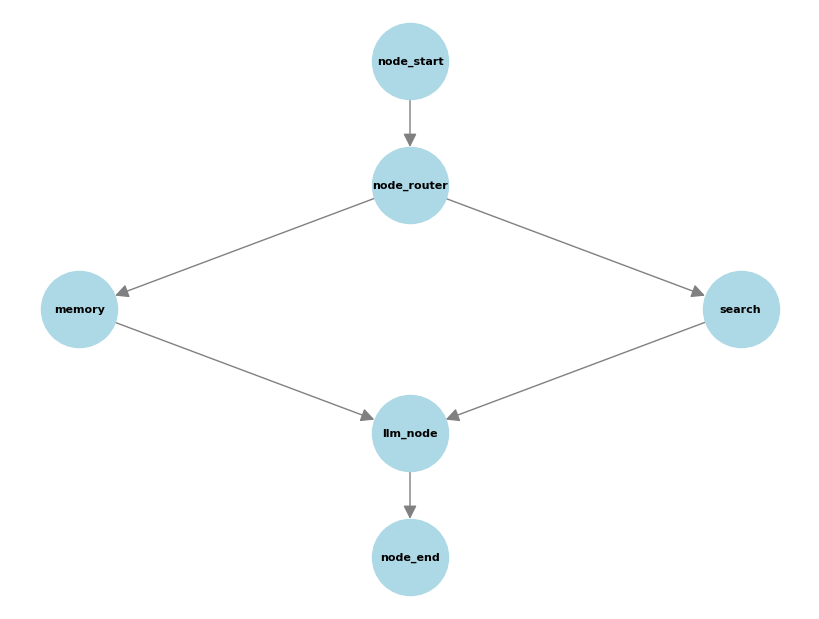

In [28]:
for node_fn in [node_start, memory, search, llm_node, node_end]:
    graph.add_node(node_fn)

# add the router
graph.add_router(
    sources=[node_start],
    router=node_router,
    destinations=[memory, search]
)

# build the certain edges
graph.add_edge(source=node_start, destination=node_router)
graph.add_edge(source=memory, destination=llm_node)
graph.add_edge(source=search, destination=llm_node)
graph.add_edge(source=llm_node, destination=node_end)

graph.visualize()

In [29]:
graph.compile()

In [30]:
chat_history = []

In [31]:
query = "do you remember where I am?"

chat_history.append({"role": "user", "content": query})
response = await graph.execute(
    input={"input": {"query": query, "chat_history": chat_history}}
)
response

>>> node_start
>>> node_router
>>> memory
>>> llm_node


{'input': {'text': 'The user is in Bali right now.',
  'query': "user's location",
  'chat_history': [{'role': 'user', 'content': 'do you remember where I am?'}],
  'answer': 'You are currently in Bali.',
  'sources': 'User mentioned their location as Bali.'},
 'choice': 'finalanswer'}

In [32]:
import asyncio

callback = graph.get_callback()

query = "tell me a long story"
response = asyncio.create_task(graph.execute(
    input={"input": {"query": query, "chat_history": chat_history}}
))

async for token in callback.aiter():
    print(token)

>>> node_start
>>> node_router
<graphai:start:node_router>
<graphai:toolname:memory>
{"
query
":"
long
 story
"}
>>> memory
>>> llm_node
<graphai:end:node_router>
<graphai:start:memory>
The user is in Bali right now.
<graphai:end:memory>
<graphai:start:llm_node>
<graphai:toolname:finalanswer>
{"
answer
":"
It
 sounds
 like
 you're
 in
 an
 intriguing
 situation
!
 Bali
 is
 a
 beautiful
 place
 with
 rich
 culture
 and
 stunning
 scenery
.
 If
 you'd
 like
 to
 share
 your
 long
 story
 or
 if
 there's
 something
 specific
 on
 your
 mind
,
 feel
 free
 to
 tell
 me
 more
!
","
sources
":"
N
/A
"}
<graphai:end:llm_node>
<graphai:END>
